# SVM Tuning (Descriptors + Fingerprints)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)

from sklearn.svm import SVC
import shap
import optuna

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor + Fingerprints and Outlier Functions


In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog("rdApp.*")
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(
        mol, nBits=tt_bits
    )
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog("rdApp.*")

    return feats

## Dataset Processing


In [ ]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    fp_feats = calculate_fingerprints(molecule)

    # Merge both dicts into one feature row
    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)], axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
# Splitting the dataset to Fingerprint and Descriptor sets
FP_PREFIXES = (
    "Morgan",
    "RDK_",
    "MACCS",
    "AtomPair_",
    "Torsion_",
)  # Identify fingerprint columns by prefix
fp_cols = [c for c in X_train.columns if c.startswith(FP_PREFIXES)]
desc_cols = [c for c in X_train.columns if c not in fp_cols]

print(f"Descriptor columns: {len(desc_cols)}, fingerprint columns: {len(fp_cols)}")

scaler = StandardScaler()
if desc_cols:
    X_train_desc_scaled = scaler.fit_transform(X_train[desc_cols])
    X_test_desc_scaled = scaler.transform(X_test[desc_cols])

    # Start from copies so we keep original indexing and all columns
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Overwrite only descriptor columns with scaled values
    X_train_scaled[desc_cols] = X_train_desc_scaled
    X_test_scaled[desc_cols] = X_test_desc_scaled
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

X_train = X_train_scaled
X_test = X_test_scaled

# Save processed datasets
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8589
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

## Base Model Train


In [4]:
# SVM pipeline: scale features + RBF-kernel SVM with calibrated probabilities
base_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance (SVM):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance (SVM):
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.7852

Classification report:
              precision    recall  f1-score   support

           0      0.600     0.800     0.686        15
           1      0.769     0.556     0.645        18

    accuracy                          0.667        33
   macro avg      0.685     0.678     0.665        33
weighted avg      0.692     0.667     0.664        33



## Feature Selection


PermutationExplainer explainer: 130it [15:09,  7.10s/it]                         
/tmp/ipykernel_44579/2953739021.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


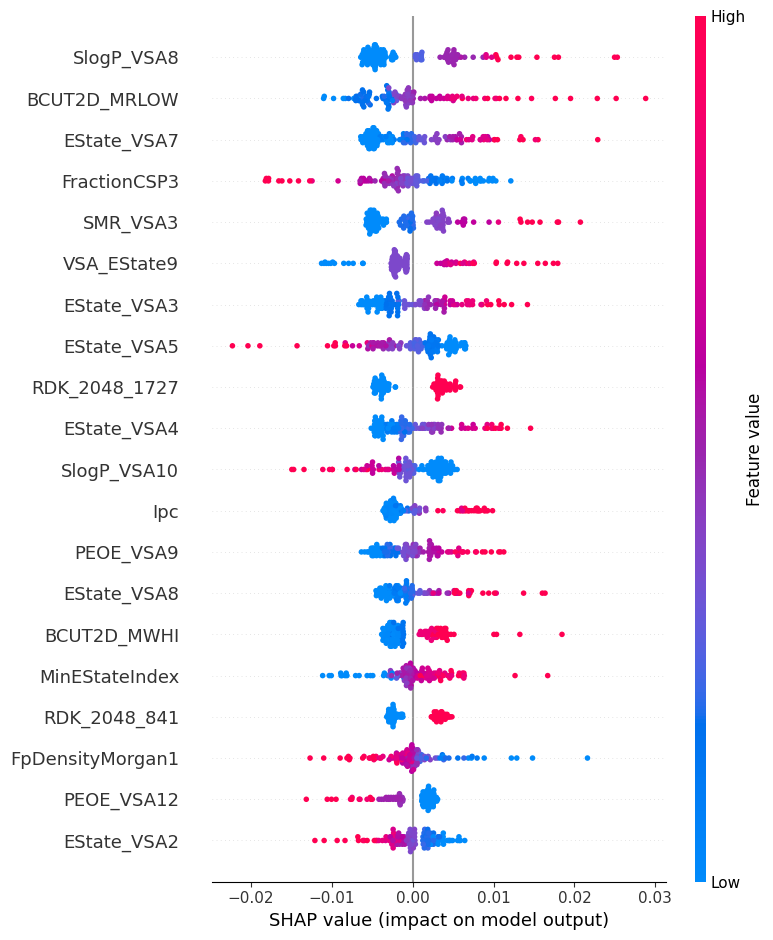


Top 10 SHAP features:
SlogP_VSA8       0.005353
BCUT2D_MRLOW     0.004847
EState_VSA7      0.004804
FractionCSP3     0.004426
SMR_VSA3         0.004386
VSA_EState9      0.004099
EState_VSA3      0.004060
EState_VSA5      0.004032
RDK_2048_1727    0.003825
EState_VSA4      0.003667

Top 10 K-Best features:
RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_1387    26.473703

Top 10 Lasso features:
RDK_2048_841         1.575227
AtomPair_2048_760    1.097054
RDK_2048_1441        0.839866
VSA_EState9          0.838143
AtomPair_2048_888    0.780494
RDK_2048_460         0.773327
RDK_2048_1827        0.670789
RDK_2048_1038        0.666206
RDK_2048_52          0.642455
RDK_2048_1421        0.599671


In [5]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k="all")
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

## SHAP Features


In [6]:
shap_features.head(20)

SlogP_VSA8          0.005353
BCUT2D_MRLOW        0.004847
EState_VSA7         0.004804
FractionCSP3        0.004426
SMR_VSA3            0.004386
VSA_EState9         0.004099
EState_VSA3         0.004060
EState_VSA5         0.004032
RDK_2048_1727       0.003825
EState_VSA4         0.003667
SlogP_VSA10         0.003369
Ipc                 0.003241
PEOE_VSA9           0.003154
EState_VSA8         0.002986
BCUT2D_MWHI         0.002939
MinEStateIndex      0.002834
RDK_2048_841        0.002827
FpDensityMorgan1    0.002666
PEOE_VSA12          0.002585
EState_VSA2         0.002512
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.706154  0.723709    0.709799
1      6     0.682462  0.721605    0.703114
2      7     0.690462  0.718460    0.726007
3      8     0.682462  0.703827    0.718956
4      9     0.713538  0.721916    0.767582

Best number of features by CV F1: 68
Top_N          68.000000
CV_Accuracy     0.783692
CV_F1           0.799691
CV_ROC_AUC      0.858516
Name: 63, dtype: float64


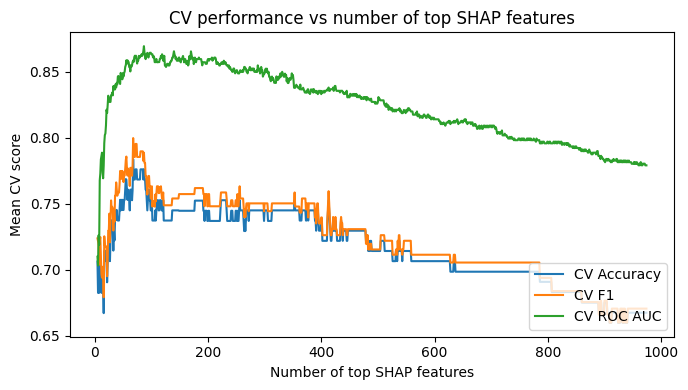

In [7]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1):
    top_feats = shap_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features


In [8]:
kbest_features.head(20)

RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_1387    26.473703
RDK_2048_865     26.473703
RDK_2048_354     25.784260
RDK_2048_84      24.605035
RDK_2048_233     24.605035
RDK_2048_808     24.507216
RDK_2048_1993    24.507216
RDK_2048_1184    24.505004
RDK_2048_534     23.567010
RDK_2048_1443    23.567010
RDK_2048_195     23.449508
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.752308  0.760593    0.840385
1      6     0.767692  0.776184    0.856639
2      7     0.767692  0.778684    0.836951
3      8     0.775385  0.781960    0.831410
4      9     0.767692  0.771589    0.834158

Best number of features by CV F1: 19
Top_N          19.000000
CV_Accuracy     0.798462
CV_F1           0.811669
CV_ROC_AUC      0.870238
Name: 14, dtype: float64


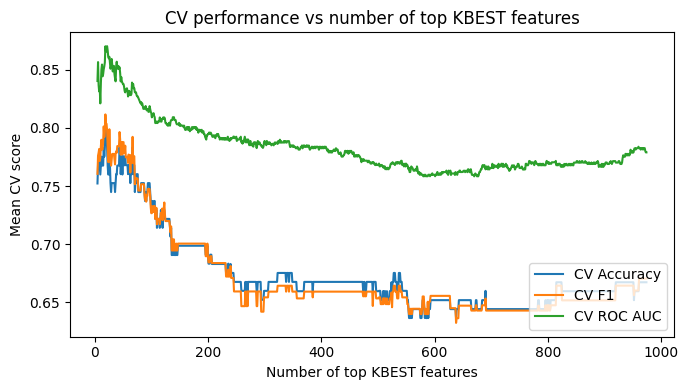

In [9]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1):
    top_feats = kbest_features.head(n).index

    # model = xgb.XGBClassifier(
    #     objective="binary:logistic", eval_metric=["logloss", "auc"], random_state=42
    # )

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features


In [10]:
lasso_features.head(20)

RDK_2048_841         1.575227
AtomPair_2048_760    1.097054
RDK_2048_1441        0.839866
VSA_EState9          0.838143
AtomPair_2048_888    0.780494
RDK_2048_460         0.773327
RDK_2048_1827        0.670789
RDK_2048_1038        0.666206
RDK_2048_52          0.642455
RDK_2048_1421        0.599671
RDK_2048_1221        0.584305
Ipc                  0.583834
RDK_2048_1951        0.570695
RDK_2048_1727        0.561702
RDK_2048_766         0.558345
RDK_2048_1121        0.518843
RDK_2048_1737        0.506625
SMR_VSA3             0.500591
EState_VSA8          0.488181
RDK_2048_1191        0.481017
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.806462  0.830225    0.839057
1      6     0.806462  0.831138    0.853205
2      7     0.821846  0.839240    0.872436
3      8     0.837231  0.849472    0.867353
4      9     0.759692  0.777468    0.852885

Best number of features by CV F1: 34
Top_N          34.000000
CV_Accuracy     0.876308
CV_F1           0.881341
CV_ROC_AUC      0.956685
Name: 29, dtype: float64


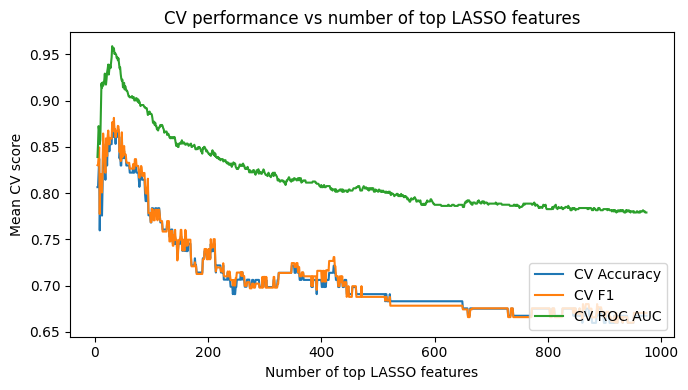

In [11]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1):
    top_feats = lasso_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features


In [12]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7296


## Model KBEST Features


In [13]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7481


## Model LASSO Features


In [14]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7148


## Model SHAP Features Tuning


In [15]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 22. Best value: 0.890934:  30%|██▉       | 59/200 [00:01<00:04, 32.88it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 99. Best value: 0.89826: 100%|██████████| 200/200 [00:05<00:00, 33.79it/s]


Best trial:
  Value: 0.8982600732600732
  Params:
    kernel: poly
    C: 2.550897902327797
    class_weight: None
    shrinking: False
    tol: 0.0015477303637474644
    max_iter: -1
    gamma_mode: scale
    degree: 3
    coef0: 0.057179882607866654

Final Optuna model (SHAP):
Accuracy:  0.6364
Precision: 0.7500
Recall:    0.5000
F1 score:  0.6000
ROC AUC:   0.7926


## Model KBEST Features Tuning


In [16]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 1. Best value: 0.79548:   2%|▏         | 4/200 [00:00<00:04, 41.92it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1


Best trial:
  Value: 0.8194854953475643
  Params:
    kernel: rbf
    C: 0.9340336454621032
    class_weight: None
    shrinking: False
    tol: 0.0010487028530223829
    max_iter: -1
    gamma_mode: scale

Final Optuna model (KBEST):
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7370


## Model LASSO Features Tuning


In [17]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 21. Best value: 0.991667:  18%|█▊        | 36/200 [00:00<00:03, 49.76it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 55. Best value: 0.994048:  58%|█████▊    | 116/200 [00:02<00:01, 43.70it/s]/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 55. Best value: 0.994048:  84%|████████▎ | 167/200 [00:0


Best trial:
  Value: 0.994047619047619
  Params:
    kernel: linear
    C: 0.45789438894366163
    class_weight: balanced
    shrinking: True
    tol: 0.00013411099156501342
    max_iter: -1
    gamma_mode: scale

Final Optuna model (LASSO):
Accuracy:  0.5758
Precision: 0.6429
Recall:    0.5000
F1 score:  0.5625
ROC AUC:   0.6630


## Model SHAP Features Tuning (Randomized Search CV)


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war


=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0014314589375234786), 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.606 | ROC-AUC: 0.600

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.606 | ROC-AUC: 0.541

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.581

=== Testing top 8 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0014314589375234786), 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.606 | ROC-AUC: 0.600

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0021461411978584057), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.002300430119772917)}
Accuracy: 0.545 | ROC-AUC: 0.578

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.652

=== Testing top 11 features ===
Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.344

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.359

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.341

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.545 | ROC-AUC: 0.669

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.678

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.71486636345739e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.009658832241158708), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.545 | ROC-AUC: 0.326

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.681

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.545 | ROC-AUC: 0.667

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.656

=== Testing top 20 features ===
Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.424 | ROC-AUC: 0.659

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.424 | ROC-AUC: 0.689

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.678

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.726

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.719

=== Testing top 25 features ===
Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.730

=== Testing top 26 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.667 | ROC-AUC: 0.741

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.636 | ROC-AUC: 0.726

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.636 | ROC-AUC: 0.722

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.515 | ROC-AUC: 0.748

=== Testing top 30 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.759

=== Testing top 31 features ===
Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.763

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.770

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.756

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 35 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.748

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.756

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.741

=== Testing top 38 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.733

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.730

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.748

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.752

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.759

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.763

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.763

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(1.3987131026472386), 'degree': 3, 'coef0': np.float64(1.0), 'class_weight': None, 'C': np.float64(0.17027691722258995)}
Accuracy: 0.606 | ROC-AUC: 0.796

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0005179474679231213), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(8.406652885618334), 'degree': 3, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.07934096665797492)}
Accuracy: 0.606 | ROC-AUC: 0.796

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004291934260128779), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.05170920242896761), 'degree': 3, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(535.3566677410719)}
Accuracy: 0.606 | ROC-AUC: 0.796

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.767

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.759

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.752

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.636 | ROC-AUC: 0.681

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 2, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.636 | ROC-AUC: 0.685

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.021711179456945052), 'degree': 2, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(0.9658832241158698)}
Accuracy: 0.636 | ROC-AUC: 0.726


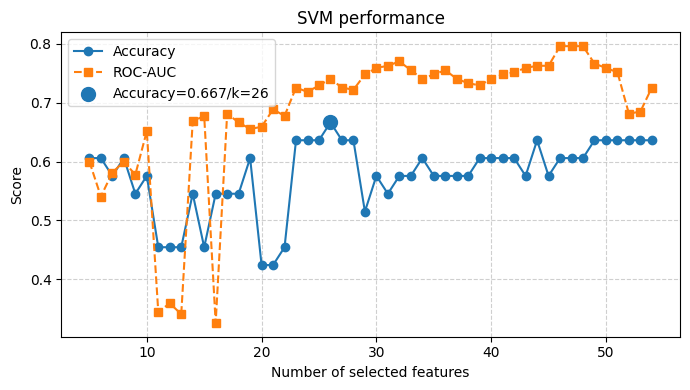


Accuracy = 0.667 | ROC-AUC = 0.741 | k = 26


In [18]:
ranking = shap_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)



=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.636 | ROC-AUC: 0.648

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.667 | ROC-AUC: 0.691

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.667 | ROC-AUC: 0.687

=== Testing top 8 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.727 | ROC-AUC: 0.696

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.545 | ROC-AUC: 0.700

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.021711179456945052), 'degree': 2, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(0.9658832241158698)}
Accuracy: 0.545 | ROC-AUC: 0.733

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.17426333860096507), 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.12033778407775893)}
Accuracy: 0.727 | ROC-AUC: 0.735

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.001011637979766207), 'coef0': np.float64(0.05), 'class_weight': None, 'C': np.float64(0.006080224261649421)}
Accuracy: 0.545 | ROC-AUC: 0.724

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.00042475715525368984), 'degree': 2, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.00429700470432084)}
Accuracy: 0.545 | ROC-AUC: 0.720

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.739

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.724

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.730

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.00042475715525368984), 'degree': 2, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.00429700470432084)}
Accuracy: 0.545 | ROC-AUC: 0.711

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.00042475715525368984), 'degree': 2, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.00429700470432084)}
Accuracy: 0.545 | ROC-AUC: 0.715

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.001011637979766207), 'coef0': np.float64(0.05), 'class_weight': None, 'C': np.float64(0.006080224261649421)}
Accuracy: 0.545 | ROC-AUC: 0.707

=== Testing top 20 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.545 | ROC-AUC: 0.722

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.576 | ROC-AUC: 0.748

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.001011637979766207), 'coef0': np.float64(0.05), 'class_weight': None, 'C': np.float64(0.006080224261649421)}
Accuracy: 0.545 | ROC-AUC: 0.741

=== Testing top 23 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.752

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.756

=== Testing top 25 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.759

=== Testing top 26 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.744

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.763

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.763

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.763

=== Testing top 30 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.744

=== Testing top 31 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.756

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.576 | ROC-AUC: 0.685

=== Testing top 33 features ===
Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.719

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.737

=== Testing top 35 features ===
Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.730

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 37 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.576 | ROC-AUC: 0.730

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.719

=== Testing top 40 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.733

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.733

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.733

=== Testing top 43 features ===
Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.781

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.785

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.785

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.781

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.778

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.606 | ROC-AUC: 0.778

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.778

=== Testing top 51 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.606 | ROC-AUC: 0.778

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.774

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.767

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.774


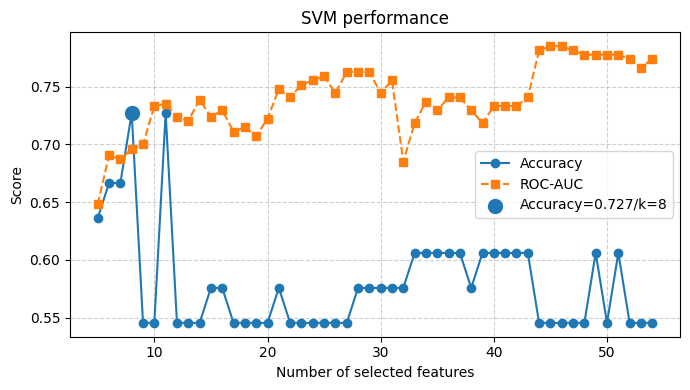


Accuracy = 0.727 | ROC-AUC = 0.696 | k = 8


In [19]:
ranking = kbest_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)



=== Testing top 5 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.8309941949353395), 'degree': 4, 'coef0': np.float64(1.0), 'class_weight': 'balanced', 'C': np.float64(0.17027691722258995)}
Accuracy: 0.667 | ROC-AUC: 0.663

=== Testing top 6 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.633

=== Testing top 7 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.636 | ROC-AUC: 0.615

=== Testing top 8 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.594

=== Testing top 9 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.637

=== Testing top 10 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.576 | ROC-AUC: 0.589

=== Testing top 11 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.576 | ROC-AUC: 0.589

=== Testing top 12 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.636 | ROC-AUC: 0.622

=== Testing top 13 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.636 | ROC-AUC: 0.644

=== Testing top 14 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.697 | ROC-AUC: 0.652

=== Testing top 15 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.697 | ROC-AUC: 0.633

=== Testing top 16 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.637

=== Testing top 17 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.633

=== Testing top 18 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.596

=== Testing top 19 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.667 | ROC-AUC: 0.633

=== Testing top 20 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.637

=== Testing top 21 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.644

=== Testing top 22 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.667

=== Testing top 23 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.626

=== Testing top 24 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.630

=== Testing top 25 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.685

=== Testing top 26 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.663

=== Testing top 27 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.663

=== Testing top 28 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.545 | ROC-AUC: 0.681

=== Testing top 29 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  war

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.670

=== Testing top 30 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.652

=== Testing top 31 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.633

=== Testing top 32 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.606 | ROC-AUC: 0.678

=== Testing top 33 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.681

=== Testing top 34 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.678

=== Testing top 35 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.689

=== Testing top 36 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.636 | ROC-AUC: 0.678

=== Testing top 37 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.685

=== Testing top 38 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.696

=== Testing top 39 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.670

=== Testing top 40 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.674

=== Testing top 41 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.674

=== Testing top 42 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.663

=== Testing top 43 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.659

=== Testing top 44 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.659

=== Testing top 45 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.606 | ROC-AUC: 0.670

=== Testing top 46 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.636 | ROC-AUC: 0.667

=== Testing top 47 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.636 | ROC-AUC: 0.674

=== Testing top 48 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.636 | ROC-AUC: 0.693

=== Testing top 49 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.636 | ROC-AUC: 0.656

=== Testing top 50 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.656

=== Testing top 51 features ===
Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.659

=== Testing top 52 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.663

=== Testing top 53 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.606 | ROC-AUC: 0.663

=== Testing top 54 features ===


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.636 | ROC-AUC: 0.681


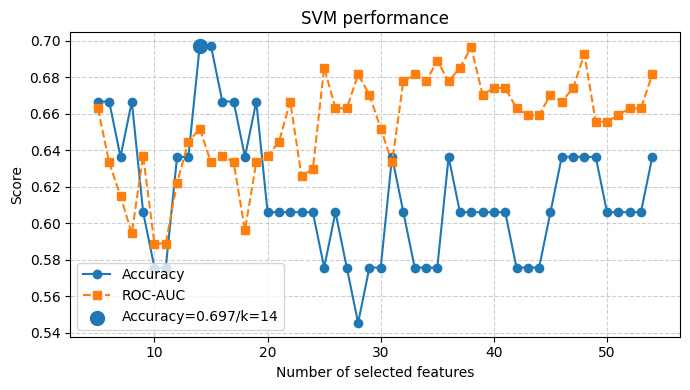


Accuracy = 0.697 | ROC-AUC = 0.652 | k = 14


In [20]:
ranking = lasso_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")